In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize

In [2]:
df=pd.read_csv('Final_reddit.csv')

In [3]:
df.drop(columns='Unnamed: 0', inplace=True)

In [4]:
df.head()

,ID,comments,posts,roles,predicates,labels,flesch_score_posts,processed_comments,flesch_score_comments,post_caps,...,disgust_comments,surprise_comments,neutral_comments,anger_comments,sad_comments,happy_comments,fear_comments,comments_count,post_avg_word_length,comments_avg_word_length
0,hgz26,"[""If the cops won't do anything about it... ma...",My father abuses me and I cant do anything abo...,"['am-adv', 'am-adv', 'am-adv', 'am-adv', 'am-d...","[('do', '02'), ('know', '01'), ('make', '01'),...",abuse,84.81,cop anything aspca bother cop straight social ...,83.76,0.020972,...,0.006387,0.024705,0.003556,0.029930,0.020565,0.021733,0.028812,29,5.106061,5.234305
1,2vpmnh,"[""I re-read your post and realized it's past t...",[Help]Finger Prick I know how dumb it sounds o...,"['am-adv', 'am-adv', 'am-dis', 'am-mnr', 'am-m...","[('!think', '01'), ('be', '01'), ('have', '03'...",non_abuse,85.42,read post realized past time already hope ever...,72.56,0.041131,...,0.006047,0.020780,0.002419,0.015285,0.026523,0.027244,0.030113,4,5.112245,5.215625
2,2urnes,"[""Dealing with seniors? What exactly does that...",Going to college stress. I've had two panic at...,"['am-mnr', 'emotion or sensation', 'end point,...","[('do', '02'), ('feel', '01'), ('go', '01'), (...",non_abuse,80.78,dealing senior exactly mean college typical hi...,86.20,0.030457,...,0.005086,0.017478,0.001507,0.010174,0.018588,0.027902,0.011612,2,5.555556,5.172662
3,2l78vr,"['Yeah I am the same I get terrible anxiety, t...",Just started my Sertraline medication today. I...,"['am-adv', 'am-adv', 'am-dis', 'am-mnr', 'am-m...","[('change', '01'), ('start', '01'), ('change',...",non_abuse,70.13,yeah terrible anxiety terrified people judging...,76.22,0.039604,...,0.001349,0.026620,0.000961,0.052914,0.020810,0.022443,0.022567,2,5.283784,5.166667
4,136f5k,"[""So what I am getting is you're suffering fro...","hear me, i cry again and again, and maybe i am...","['am-adv', 'am-adv', 'am-adv', 'am-adv', 'am-a...","[('!be', '01'), ('be', '01'), ('do', '02'), ('...",abuse,78.93,getting suffering anxiety depression presumabl...,76.25,0.000000,...,0.003951,0.009974,0.000497,0.039433,0.016787,0.020754,0.018082,2,4.715328,5.198413


In [5]:
models=pd.DataFrame(index=['Naive Bayes Classifier', 'Random Forest Classifier', 'Logistic Regression'],\
                    columns=['Best min_df for CountVectorizer', 'Best Parameters', 'ROC AUC Score'])

# Modeling

## Naive Bayes Classifier

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

In [7]:
def pick_min_df(X, y, min_df_range=20, prefix='post', clf='nb'):
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=123)
    pick_df=pd.DataFrame({}, columns=[prefix+'_test_accuracy'])
    for i in range(min_df_range):
        vect=CountVectorizer(min_df=i)
        #dtm: document-term matrix
        X_train_dtm=vect.fit_transform(X_train)
        X_test_dtm=vect.transform(X_test)
        if clf=='nb':
            clf=MultinomialNB()
        elif clf=='rfc':
            clf=RandomForestClassifier(random_state=123)
        elif clf=='lr':
            clf=LogisticRegression(random_state=123)
        clf.fit(X_train_dtm, y_train)
        y_pred=clf.predict(X_test_dtm)
        y_pred_prob=clf.predict_proba(X_test_dtm)[:,1]
        pick_df=pd.concat([pick_df, pd.DataFrame({prefix+'_test_accuracy':[roc_auc_score(y_test, y_pred_prob)]})])
    pick_df=pick_df.reset_index(drop=True)
    
    return pick_df[pick_df[prefix+'_test_accuracy']==max(pick_df[prefix+'_test_accuracy'])]


In [8]:
pick_min_df(df.tokens, df.labels_num, prefix='post_and_comments')

,post_and_comments_test_accuracy
0,0.986527
1,0.986527


In [9]:
pick_min_df(df.p_tokens, df.labels_num)

,post_test_accuracy
0,0.966994
1,0.966994


In [10]:
pick_min_df(df.c_tokens, df.labels_num, prefix='comment')

,comment_test_accuracy
9,0.955692


In [11]:
models['Best min_df for CountVectorizer'][0]=1

We pick a min_df of 1 for X containing both posts and comments.

In [12]:
X_train, X_test, y_train, y_test=train_test_split(df.tokens, df.labels_num, test_size=0.2, random_state=123)
vect=CountVectorizer(min_df=1)
X_train_dtm=vect.fit_transform(X_train)
X_test_dtm=vect.transform(X_test)
nb=MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred=nb.predict(X_test_dtm)
y_pred_prob=nb.predict_proba(X_test_dtm)[:,1]

In [13]:
roc_auc_score(y_test, y_pred_prob) #same as nb.score(X_test_dtm,y_test)

0.9865274365274365

In [14]:
nb.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [15]:
from sklearn.model_selection import GridSearchCV
param_grid={'alpha':[.001, .01, .1, .5, 1, 5, 10, 50, 100, 1000]}
nb_cv=GridSearchCV(nb, param_grid, scoring='roc_auc', cv=5)
nb_cv.fit(X_train_dtm, y_train)
print("Tuned Naive Bayes Parameter: {}".format(nb_cv.best_params_))
print("Tuned Naive Bayes ROC_AUC Score: {}".format(nb_cv.best_score_))

Tuned Naive Bayes Parameter: {'alpha': 1}
Tuned Naive Bayes ROC_AUC Score: 0.9604218416287491


In [16]:
models['Best Parameters'][0]=nb_cv.best_params_

We pick a Naive Bayes Parameter alpha=1 with a CountVectorizer parameter min_df of 1 for both posts and comments.

In [17]:
X_train, X_test, y_train, y_test=train_test_split(df.tokens, df.labels_num, test_size=0.2, random_state=123)
vect=CountVectorizer(min_df=1)
X_train_dtm=vect.fit_transform(X_train)
X_test_dtm=vect.transform(X_test)
nb=MultinomialNB(alpha=1)
nb.fit(X_train_dtm, y_train)
y_pred=nb.predict(X_test_dtm)
y_pred_prob=nb.predict_proba(X_test_dtm)[:,1]
nb_fpr, nb_tpr, nb_thresholds=roc_curve(y_test, y_pred_prob) 

In [18]:
models['ROC AUC Score'][0]=roc_auc_score(y_test, y_pred_prob)

## Random Forest Classifier

In [19]:
pick_min_df(df.tokens, df.labels_num, prefix='post_and_comments', clf='rfc')

,post_and_comments_test_accuracy
14,0.967281


In [20]:
pick_min_df(df.p_tokens, df.labels_num, clf='rfc')

,post_test_accuracy
17,0.954177


In [21]:
pick_min_df(df.c_tokens, df.labels_num, prefix='comment', clf='rfc')

,comment_test_accuracy
5,0.959582


In [22]:
models['Best min_df for CountVectorizer'][1]=14

In [23]:
X_train, X_test, y_train, y_test=train_test_split(df.tokens, df.labels_num, test_size=0.2, random_state=123)
vect=CountVectorizer(min_df=14)
X_train_dtm=vect.fit_transform(X_train)
X_test_dtm=vect.transform(X_test)
rfc=RandomForestClassifier(random_state=123)
rfc.fit(X_train_dtm, y_train)
y_pred=rfc.predict(X_test_dtm)
y_pred_prob=rfc.predict_proba(X_test_dtm)[:,1]

In [24]:
roc_auc_score(y_test, y_pred_prob) 

0.9672809172809173

In [25]:
param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 1, 3, 5, 7, 15, 30],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 50, 100, 300, 500, 700, 1000]}

rfc_cv=GridSearchCV(rfc, param_grid, scoring='roc_auc', cv=5)
rfc_cv.fit(X_train_dtm, y_train)
print("Tuned Random Forest Classifier Parameter: {}".format(rfc_cv.best_params_))
print("Tuned Random Forest Classifier ROC_AUC Score: {}".format(rfc_cv.best_score_))

Tuned Random Forest Classifier Parameter: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 700}
Tuned Random Forest Classifier ROC_AUC Score: 0.9692531804252947


In [26]:
models['Best Parameters'][1]=rfc_cv.best_params_

In [27]:
X_train, X_test, y_train, y_test=train_test_split(df.tokens, df.labels_num, test_size=0.2, random_state=123)
vect=CountVectorizer(min_df=14)
X_train_dtm=vect.fit_transform(X_train)
X_test_dtm=vect.transform(X_test)
rfc=RandomForestClassifier(random_state=123, criterion='entropy', max_depth=None, max_features='log2', n_estimators=700)
rfc.fit(X_train_dtm, y_train)
y_pred=rfc.predict(X_test_dtm)
y_pred_prob=rfc.predict_proba(X_test_dtm)[:,1]
rfc_fpr, rfc_tpr, rfc_thresholds = roc_curve(y_test, y_pred_prob) 

In [28]:
models['ROC AUC Score'][1]=roc_auc_score(y_test, y_pred_prob)

## Logistic Regression

In [29]:
pick_min_df(df.tokens, df.labels_num, prefix='post_and_comments', clf='lr')

,post_and_comments_test_accuracy
0,0.969861
1,0.969861


In [30]:
pick_min_df(df.p_tokens, df.labels_num, clf='lr')

,post_test_accuracy
0,0.934152
1,0.934152


In [31]:
pick_min_df(df.c_tokens, df.labels_num, prefix='comment', clf='lr')

,comment_test_accuracy
2,0.943735


In [32]:
models['Best min_df for CountVectorizer'][2]=1

In [33]:
X_train, X_test, y_train, y_test=train_test_split(df.tokens, df.labels_num, test_size=0.2, random_state=123)
vect=CountVectorizer(min_df=1)
X_train_dtm=vect.fit_transform(X_train)
X_test_dtm=vect.transform(X_test)
lr=LogisticRegression(random_state=123)
lr.fit(X_train_dtm, y_train)
y_pred=lr.predict(X_test_dtm)
y_pred_prob=lr.predict_proba(X_test_dtm)[:,1]

In [34]:
roc_auc_score(y_test, y_pred_prob) 

0.9698607698607699

In [35]:
param_grid={'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
lr_cv=GridSearchCV(lr, param_grid, scoring='roc_auc', cv=5)
lr_cv.fit(X_train_dtm, y_train)
print("Tuned Logistic Regression Parameter: {}".format(lr_cv.best_params_))
print("Tuned Logistic Regression ROC_AUC Score: {}".format(lr_cv.best_score_))

Tuned Logistic Regression Parameter: {'C': 0.1}
Tuned Logistic Regression ROC_AUC Score: 0.9774535123966943


In [36]:
models['Best Parameters'][2]=lr_cv.best_params_

In [37]:
X_train, X_test, y_train, y_test=train_test_split(df.tokens, df.labels_num, test_size=0.2, random_state=123)
vect=CountVectorizer(min_df=1)
X_train_dtm=vect.fit_transform(X_train)
X_test_dtm=vect.transform(X_test)
lr=LogisticRegression(random_state=123, C=0.1)
lr.fit(X_train_dtm, y_train)
y_pred=lr.predict(X_test_dtm)
y_pred_prob=lr.predict_proba(X_test_dtm)[:,1]
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, y_pred_prob) 

In [38]:
models['ROC AUC Score'][2]=roc_auc_score(y_test, y_pred_prob)

In [39]:
pd.set_option('display.max_colwidth', None)
models

,Best min_df for CountVectorizer,Best Parameters,ROC AUC Score
Naive Bayes Classifier,1,{'alpha': 1},0.986527
Random Forest Classifier,14,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 700}",0.979075
Logistic Regression,1,{'C': 0.1},0.972727


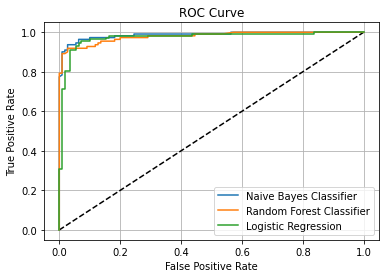

In [40]:
plt.plot([0,1],[0,1],'k--')
plt.plot(nb_fpr, nb_tpr, label='Naive Bayes Classifier') 
plt.plot(rfc_fpr, rfc_tpr, label='Random Forest Classifier') 
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression') 
plt.grid()
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve') 
plt.show()

## Feature Importances

In [41]:
from sklearn.metrics import precision_recall_curve, fbeta_score, ConfusionMatrixDisplay, classification_report, confusion_matrix

In [42]:
X_train, X_test, y_train, y_test=train_test_split(df.tokens, df.labels_num, test_size=0.2, random_state=123)
vect=CountVectorizer(min_df=1)
X_train_dtm=vect.fit_transform(X_train)
X_test_dtm=vect.transform(X_test)
nb=MultinomialNB(alpha=1)
nb.fit(X_train_dtm, y_train)
y_pred=nb.predict(X_test_dtm)
y_pred_prob=nb.predict_proba(X_test_dtm)[:,1]
nb_fpr, nb_tpr, nb_thresholds=roc_curve(y_test, y_pred_prob) 

In [43]:
features = np.array(vect.get_feature_names_out())

x = np.eye(X_test_dtm.shape[1])
probs = nb.predict_log_proba(x)[:, 0] #using log is more precise for lower probabilities
ind = np.argsort(probs)

words = pd.DataFrame({})

words['word']=features[ind]
words['prob']=1-np.exp(probs[ind]) #log
words['post_or_comment']=['post' if 'p_' in word else 'comment' for word in words.word]

words.head(10)

,word,prob,post_or_comment
0,c_abuser,0.993384,comment
1,c_domestic,0.988783,comment
2,p_abuse,0.988035,post
3,c_dv,0.982512,comment
4,p_domestic,0.981899,post
5,c_abuse,0.980670,comment
6,p_sexually,0.977075,post
7,p_abuser,0.975439,post
8,c_healing,0.974841,comment
9,p_survivor,0.969666,post


In [44]:
words.tail(10)

,word,prob,post_or_comment
19509,c_appointment,0.051066,comment
19510,c_american,0.051066,comment
19511,c_mg,0.051066,comment
19512,c_exam,0.048509,comment
19513,c_dress,0.048509,comment
19514,p_university,0.040414,post
19515,p_company,0.040414,post
19516,c_artist,0.038795,comment
19517,c_tea,0.021541,comment
19518,c_urlyoutube,0.019005,comment


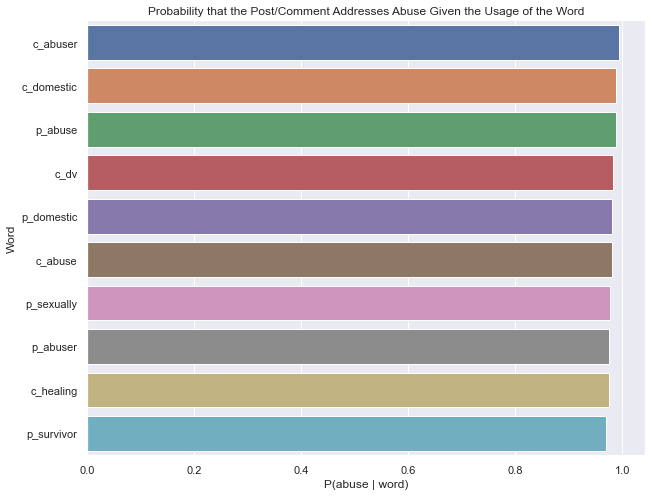

In [45]:
sns.set(rc={'figure.figsize':(10,8)})
ax=sns.barplot(x=words.prob[:10], y=words.word[:10])
ax.set(xlabel='P(abuse | word)', ylabel='Word', title='Probability that the Post/Comment Addresses Abuse Given the Usage of the Word')
plt.show();

In [73]:
def excerpt(token, label):
    for index in df[(df.tokens.str.contains(token+' '))&(df.labels==label)].index:  
        if 'p_' in token:
            sentences=df.posts[index].split('. ')
            for i in range(len(sentences)):
                if token[2:]+' ' in sentences[i].lower() or ' '+token[2:] in sentences[i].lower():
                    if len(sentences[i])>200 and len(sentences[i])<400:
                        return sentences[i]
        elif 'c_' in token:
            sentences=df.comments.apply(eval)[index]
            for i in range(len(sentences)):
                if token[2:]+' ' in sentences[i].lower() or ' '+token[2:] in sentences[i].lower():
                    if len(sentences[i])>200 and len(sentences[i])<400:
                        return sentences[i]

In [74]:
excerpt(token='c_abuser', label='abuse')

'Resist any urge to confront the abuser. Not only can this be dangerous, but if you even show any sign of disapproval to their face they will use it as an excuse to try and cut you off from ever talking to this person.'

In [75]:
excerpt(token='c_dv', label='abuse')

"Depending on where you live, there may be a law in place that releases you of a lease if you've experienced DV, reporting or not.  Talk to your local DV agency. They'll be able to give you local resources and help inform you of your rights and options."

In [76]:
excerpt(token='p_sexually', label='abuse')

"This turned out longer than I thought it would (sorry).\n\nWhen I was twelve, I'm almost 21 now, I was (not sure if I can say this but) sexually abused by a boy about a year older than me in the same grade"

In [77]:
excerpt(token='c_healing', label='abuse')

"Everyone's story is different, and everyone's experience in healing is unique. I do not doubt for a moment that I will always have the scars of my abuse, my daughter's abuse, my family's abuse, embedded on my soul. I do hope the pain of the wounds continues to subside, hopefully to a degree beyond tolerable and into the realm of memory. "

In [78]:
excerpt(token='p_survivor', label='abuse')

"\n\nAs the survivors talked about their shame, and inability to form romantic relationships, and obsessive numbing behaviors, it was like something inside me was collapsing, and suddenly those few minutes at boy scout camp came flooding back as vivid as you can imagine, and I just started crying the hardest I'd cried since losing my mother"

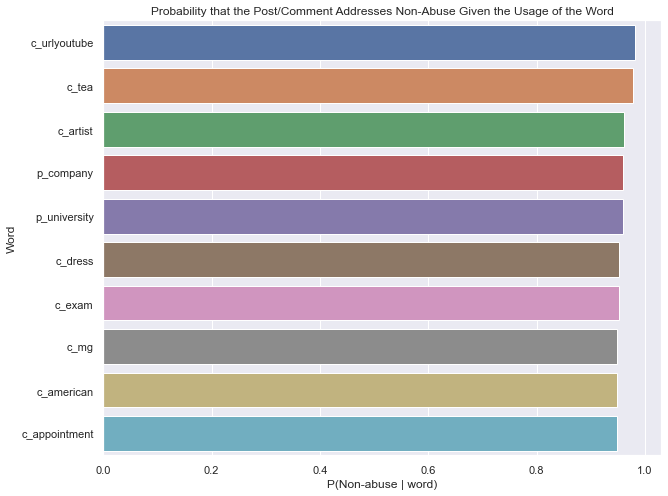

In [79]:
sns.set(rc={'figure.figsize':(10,8)})
ax=sns.barplot(x=1-words.sort_values(by='prob', ascending=True).prob[:10], y=words.sort_values(by='prob', ascending=True).word[:10])
ax.set(xlabel='P(Non-abuse | word)', ylabel='Word', title='Probability that the Post/Comment Addresses Non-Abuse Given the Usage of the Word')
plt.show();

In [129]:
df[df.comments_count>200].posts

1076    Anyone want to talk about rap music? Who's your favorite rapper? Least favorite? Why?
Name: posts, dtype: object

In [133]:
df.comments_count[1076]

207

In [132]:
df.comments.apply(eval)[1076][20]

'[lil herb - write your name](https://www.youtube.com/watch?v=2jltQphxExc)'

In [134]:
df.posts[180]

'In this thread: songs that invoke massive feels. Any genre, any type of feeling. Super simple but good lord, I am listening to a massive feels song.'

In [128]:
df.comments.apply(eval)[180][:5]

['[Gowan: A Criminal Mind creeped me the fuck out when I was little now it makes me sad for some reason](https://www.youtube.com/watch?v=yIjddye2JSA)',
 "[Phil Collins- You'll Be In My Heart because Tarzan](https://www.youtube.com/watch?v=V35oRyAMmtU)",
 '[Fuck this song and Christmas time it made me cry in a dollar store](https://www.youtube.com/watch?v=1i9G60wvH7Y)',
 '[There Is A Light That Never Goes Out - Morrissey](http://youtu.be/4ytrv2c32kM)',
 'If you are looking to kick those feels into high gear here is a list of songs that will put you in that place.']

In [80]:
excerpt(token='c_tea', label='non_abuse')

"I think it's going to slowly get harder to find a phone with a keyboard but I'm not saying they're going away.  That being said, I'm surprised that there are some people who still use blackberrys.  I understand that that's just what people like but they aren't my cup of tea.  Android for life with me :)"

In [81]:
excerpt(token='c_artist', label='non_abuse')

"Hey, look at it this way: it's your first draft! :) It's bound to be riddled with mistakes and whatnot. Don't worry about how bad it is; once you receive constructive criticism on your work, you'll be able to improve on your weaknesses and focus on your strengths. Writers, just like any artist or singer or doctor out there, get better the more they practice."

In [82]:
excerpt(token='p_company', label='non_abuse')

" Being in your mid 20s and having your career and family and everything figured out is extremely rare and is usually accompanied by rich parents.\n\nI think we're so used to obtaining everything instantly that we forget that moving up in a company, or finding the person we want to spend the rest of our lives with takes time"

In [83]:
excerpt(token='p_university', label='non_abuse')

'When I was applying for colleges and would bring up a university that wasn\'t here or my "backup" they would just steer the conversation towards here again, so I only ended up applying to two universities'

In [84]:
excerpt(token='c_dress', label='non_abuse')

"i've done this countless times unfortunately... Trust me trying to talk to her about it goes nowhere. Wait... What?? Are you serious? I'm not gonna fucking dress like my mother, plus they dont live together so he wont be coming over every day."

In [85]:
excerpt(token='c_american', label='non_abuse')

"I'm actually American, I just lived in Germany for 2-1/2 years. My username was inspired by German though as you can probably tell. My taste in coffee is just that German coffee is amazing. I never did try Austrian coffee. I regret that now, although I'd probably be even more spoiled than I already am."

In [86]:
excerpt(token='c_appointment', label='non_abuse')

"For my first visit to a psychiatrist, my mother actually had to make the appointment for me and drive me there because I just couldn't care enough to do it.  I was a 26 year old man.  But it helped, because I got on Wellbutrin, and it showed me that how I was feeling wasn't normal.  "

In [72]:
excerpt(token='c_exam', label='non_abuse')

'I had a similar experience the other day. The way uni exams work in Italy is that there are several sessions and you get to pick when you want to take your exam. During the exam you can "retire" (translated literally), which makes you eligible to retake that exam at another time. '

In [61]:
words[words.post_or_comment=='post'].head(10)

,word,prob,post_or_comment
2,p_abuse,0.988035,post
4,p_domestic,0.981899,post
6,p_sexually,0.977075,post
7,p_abuser,0.975439,post
9,p_survivor,0.969666,post
10,p_abused,0.968747,post
11,p_dv,0.966733,post
12,p_verbal,0.963173,post
15,p_flashback,0.950916,post
20,p_abusive,0.945036,post


In [62]:
words[words.post_or_comment=='post'].tail(10)

,word,prob,post_or_comment
19472,p_wallet,0.080933,post
19473,p_k,0.080933,post
19481,p_assignment,0.074692,post
19484,p_asks,0.074692,post
19494,p_zoloft,0.069345,post
19498,p_bird,0.064713,post
19501,p_mg,0.060660,post
19504,p_sport,0.057085,post
19514,p_university,0.040414,post
19515,p_company,0.040414,post


In [63]:
words[words.post_or_comment=='comment'].head(10)

,word,prob,post_or_comment
0,c_abuser,0.993384,comment
1,c_domestic,0.988783,comment
3,c_dv,0.982512,comment
5,c_abuse,0.980670,comment
8,c_healing,0.974841,comment
13,c_shelter,0.959959,comment
14,c_ptsd,0.952056,comment
16,c_assault,0.948466,comment
17,c_emdr,0.948466,comment
18,c_abused,0.947147,comment


In [64]:
words[words.post_or_comment=='comment'].tail(10)

,word,prob,post_or_comment
19507,c_driving,0.055451,comment
19508,c_cup,0.053908,comment
19509,c_appointment,0.051066,comment
19510,c_american,0.051066,comment
19511,c_mg,0.051066,comment
19512,c_exam,0.048509,comment
19513,c_dress,0.048509,comment
19516,c_artist,0.038795,comment
19517,c_tea,0.021541,comment
19518,c_urlyoutube,0.019005,comment


## Thresholding

We are most concerned with the cases when the model falsely predicts non-abuse.

0: Non-abuse

1: Abuse

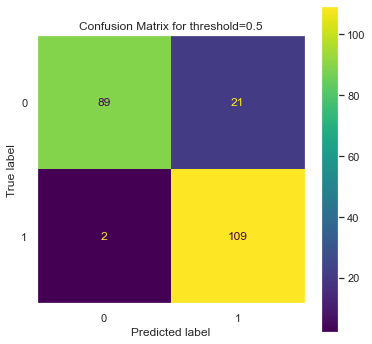

              precision    recall  f1-score   support

           0       0.98      0.81      0.89       110
           1       0.84      0.98      0.90       111

    accuracy                           0.90       221
   macro avg       0.91      0.90      0.90       221
weighted avg       0.91      0.90      0.90       221



In [65]:
fthreshold = 0.5

y_pred = (y_pred_prob >= fthreshold).astype('int')
fig, ax = plt.subplots(figsize=(6,6))
cm=confusion_matrix(y_test, y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot(ax=ax)
plt.grid(False)
plt.title('Confusion Matrix for threshold='+ str(np.round(fthreshold, 3)))
plt.show()
print(classification_report(y_test, y_pred))

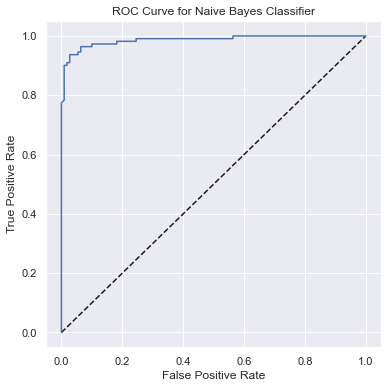

In [66]:
fig, ax=plt.subplots(figsize=(6,6))
ax.plot([0,1],[0,1],'k--')
ax.plot(nb_fpr, nb_tpr) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes Classifier') 
plt.show()

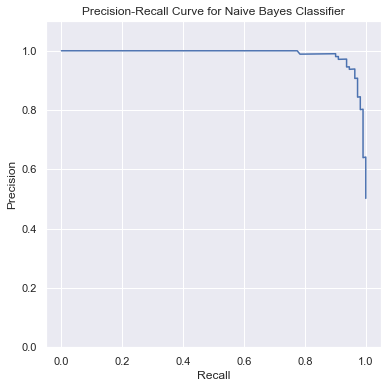

In [67]:
precision, recall, threshold = precision_recall_curve(y_test, y_pred_prob) # pos_labelstr - picks normal weight class
fig, ax=plt.subplots(figsize=(6,6))
ax.plot(recall, precision)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve for Naive Bayes Classifier')
ax.set_ylim(0.0, 1.1)
plt.show()

It seems like we can achieve a fairly high precision of nearly 84% with a high recall of 98%. We aim to minimize false negatives - abuse posts falsely mistaken for non-abuse posts, by placing more importance on recall and less on precision. However, precision seems to fall drastically around a recall of 0.87. 

In [68]:
def fbeta_score(precision, recall, beta=1.0):
    return (1+beta**2)*(precision*recall)/((beta**2)*precision+recall)

betarange=np.round(np.arange(2,3,0.05), 2)
for i in betarange:
    score=fbeta_score(precision, recall, beta=i)
    idx=np.argmax(score)
    print('Beta: '+str(i)+', Threshold: '+str(np.round(threshold[idx], 5))+', F-score: '+str(np.round(score[idx],3)))

fscore=fbeta_score(precision, recall, beta=2.8)
f_i=np.argmax(fscore)

Beta: 2.0, Threshold: 0.97116, F-score: 0.959
Beta: 2.05, Threshold: 0.97116, F-score: 0.96
Beta: 2.1, Threshold: 0.97116, F-score: 0.96
Beta: 2.15, Threshold: 0.97116, F-score: 0.961
Beta: 2.2, Threshold: 0.97116, F-score: 0.961
Beta: 2.25, Threshold: 0.97116, F-score: 0.962
Beta: 2.3, Threshold: 0.97116, F-score: 0.962
Beta: 2.35, Threshold: 0.97116, F-score: 0.962
Beta: 2.4, Threshold: 0.97116, F-score: 0.963
Beta: 2.45, Threshold: 0.97116, F-score: 0.963
Beta: 2.5, Threshold: 0.97116, F-score: 0.963
Beta: 2.55, Threshold: 0.97116, F-score: 0.964
Beta: 2.6, Threshold: 0.97116, F-score: 0.964
Beta: 2.65, Threshold: 0.97116, F-score: 0.964
Beta: 2.7, Threshold: 0.97116, F-score: 0.965
Beta: 2.75, Threshold: 0.97116, F-score: 0.965
Beta: 2.8, Threshold: 0.04154, F-score: 0.965
Beta: 2.85, Threshold: 0.04154, F-score: 0.966
Beta: 2.9, Threshold: 0.04154, F-score: 0.967
Beta: 2.95, Threshold: 0.04154, F-score: 0.968


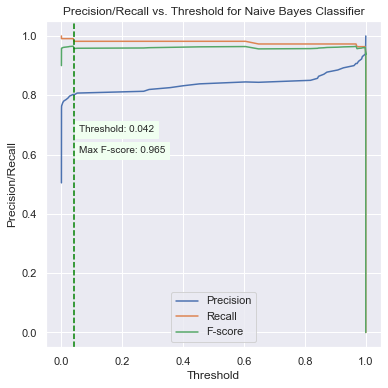

In [69]:
fig, ax=plt.subplots(figsize=(6,6))
ax.plot(threshold, precision[1:], label='Precision')
ax.plot(threshold, recall[1:], label='Recall')

ax.set_xlabel('Threshold')
ax.set_ylabel('Precision/Recall')
ax.set_title('Precision/Recall vs. Threshold for Naive Bayes Classifier')

ax.plot(threshold, fscore[1:], label='F-score')

ax.axvline(threshold[f_i], linestyle='dashed', color='green')
plt.text(threshold[f_i]*1.4, 0.675, 'Threshold: '+str(np.round(threshold[f_i], 3)), fontsize='small', backgroundcolor='honeydew')
plt.text(threshold[f_i]*1.4, 0.605, 'Max F-score: '+str(np.round(fscore[f_i], 3)), fontsize='small', backgroundcolor='honeydew')

ax.legend()
plt.show()

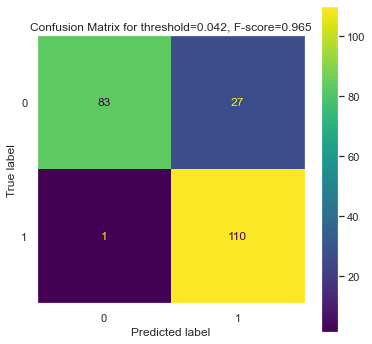

              precision    recall  f1-score   support

           0       0.99      0.75      0.86       110
           1       0.80      0.99      0.89       111

    accuracy                           0.87       221
   macro avg       0.90      0.87      0.87       221
weighted avg       0.90      0.87      0.87       221



In [70]:
fthreshold = threshold[f_i]

y_pred = (y_pred_prob >= fthreshold).astype('int')
fig, ax = plt.subplots(figsize=(6,6))
cm=confusion_matrix(y_test, y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot(ax=ax)
plt.grid(False)
plt.title('Confusion Matrix for threshold='+ str(np.round(fthreshold, 3))+ ', F-score='+str(np.round(fscore[f_i], 3)))
plt.show()
print(classification_report(y_test, y_pred))

A precision of 0.8 seems to be reasonable given a recall of 0.99.